In [32]:
!pip install transformers datasets torch scikit-learn pandas wordcloud

In [33]:
from datasets import load_dataset

# Load SST5 dataset
sst5_dataset = load_dataset("SetFit/sst5")
train_data = sst5_dataset["train"]
train_data[0]

Repo card metadata block was not found. Setting CardData to empty.


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
 'label': 4,
 'label_text': 'very positive'}

In [34]:
twitter_dataset = load_dataset("tweet_eval", "sentiment")
twt_train_data = twitter_dataset["train"]
twt_train_data[0]

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 'label': 2}

In [35]:
print(sst5_dataset)
print(sst5_dataset["train"].column_names)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})
['text', 'label', 'label_text']


In [36]:
print(twitter_dataset)
print(twitter_dataset["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
['text', 'label']


In [37]:
def convert_sst5(example):
    label = int(example["label"])
    # label = example["label"]
    if label in [0, 1]:
        return {"text": example["text"], "label": 0}
    elif label == 2:
        return {"text": example["text"], "label": 1}
    else:
        return {"text": example["text"], "label": 2}

# sst5_mapped = sst5_dataset.map(convert_sst5)
sst5_mapped = sst5_dataset.map(convert_sst5, remove_columns=["label_text"])
print(sst5_mapped["train"][0])
print(sst5_dataset["train"][0])


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 2}
{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4, 'label_text': 'very positive'}


In [38]:
from datasets import DatasetDict, Value

def convert_twitter(example):
    return {"text": example["text"], "label": int(example["label"])}


twitter_mapped = twitter_dataset.map(convert_twitter)
print(twitter_mapped["train"][0])

# Force label column to be int64 instead of ClassLabel

# twitter_mapped = DatasetDict({
#     split: ds.cast_column("label", Value("int64"))
#     for split, ds in twitter_dataset.items()
# })



{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


In [ ]:
from datasets import concatenate_datasets, DatasetDict
from datasets import ClassLabel

# Define common ClassLabel
label_class = ClassLabel(names=["negative", "neutral", "positive"])

# Ensure label columns are the same type before combining
sst5_mapped = sst5_mapped.cast_column("label", label_class)
twitter_mapped = twitter_mapped.cast_column("label", label_class)

full_combined_dataset = concatenate_datasets([
    sst5_mapped["train"], 
    sst5_mapped["test"], 
    twitter_mapped["train"], 
    twitter_mapped["test"],
    sst5_mapped["validation"], 
    twitter_mapped["validation"]
    
])

# Shuffled
full_combined_dataset = full_combined_dataset.shuffle(seed=42)




Casting the dataset:   0%|          | 0/8544 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1101 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2210 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/45615 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12284 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/71754 [00:00<?, ? examples/s]

Filter:   0%|          | 0/71754 [00:00<?, ? examples/s]

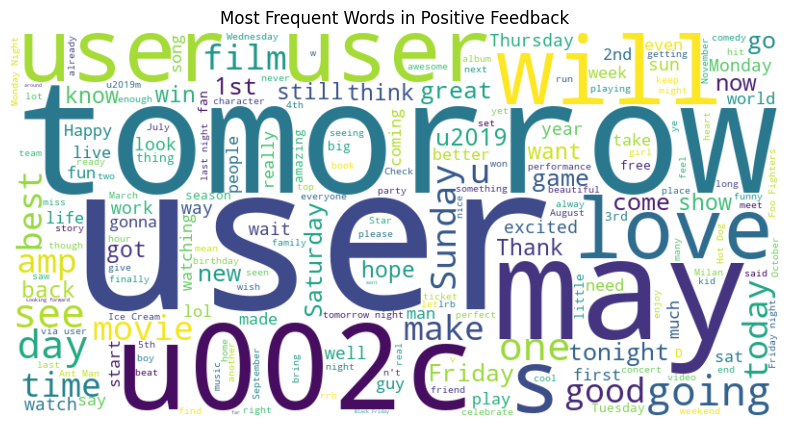

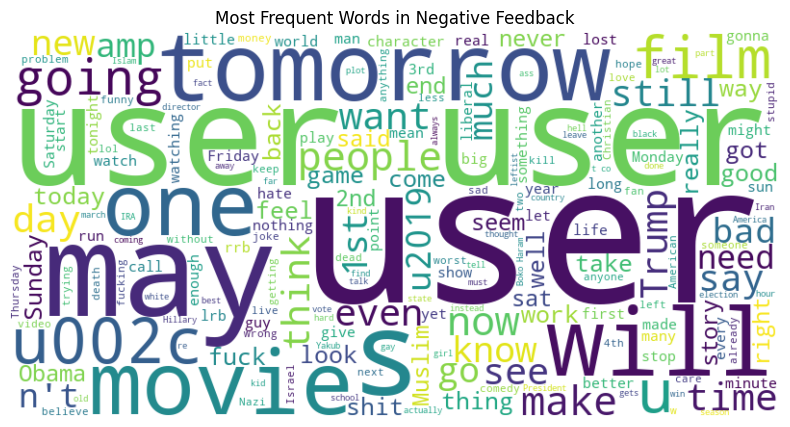

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative texts using .filter()
positive_examples = full_combined_dataset.filter(lambda x: x["label"] == 2)
negative_examples = full_combined_dataset.filter(lambda x: x["label"] == 0)

# Join all texts into a single string
positive_texts = " ".join(positive_examples["text"])
negative_texts = " ".join(negative_examples["text"])

# WordCloud for positive feedback
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Feedback")
plt.show()

# WordCloud for negative feedback
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Feedback")
plt.show()


In [45]:
# Split the combined dataset (80% train, 20% test)
combined_dataset = full_combined_dataset.train_test_split(
    test_size=0.2,
    stratify_by_column="label"  # makes sure all labels are balanced
)

combined_train = combined_dataset["train"]
combined_test = combined_dataset["test"]

In [46]:
import re
import string

def clean_text(combined_train):
    combined_train = combined_train.lower()
    combined_train = re.sub(r"http\S+|www\S+|https\S+", '', combined_train, flags=re.MULTILINE)  # Remove URLs
    combined_train = re.sub(r'\@\w+|\#', '', combined_train)  # Remove @mentions and hashtags
    combined_train = combined_train.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    combined_train = re.sub(r'\d+', '', combined_train)  # Remove digits
    combined_train = re.sub(r'\s+', ' ', combined_train).strip()  # Remove extra whitespaces
    return combined_train


In [47]:
from collections import Counter

label_counts = Counter(combined_train['label'])
print(label_counts)


Counter({1: 23777, 2: 20805, 0: 12821})


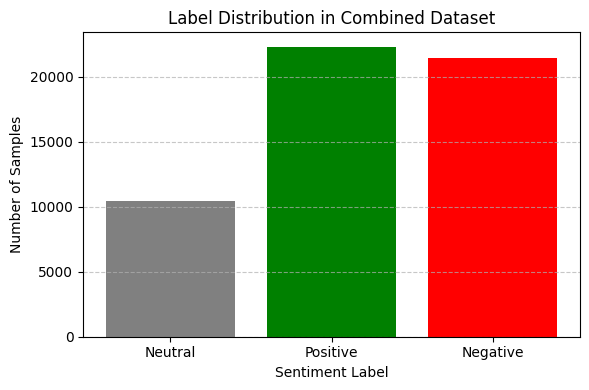

In [ ]:
# Count the number of each label
# label_counts = Counter(combined_train['label'])

# Convert keys and values to lists for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# names for readability
label_names = ['Negative', 'Neutral', 'Positive']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, tick_label=label_names, color=['red', 'gray', 'green'])
plt.title("Label Distribution in Combined Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from datasets import DatasetDict

dataset = tokenized_combined.shuffle(seed=42)
split = dataset.train_test_split(test_size=0.2, stratify_by_column="label")
combined_train = split['train']
combined_test = split['test']


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score
import numpy as np

# Load tokenizer and model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Tokenize data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets_train = combined_train.map(tokenize_function, batched=True)
tokenized_datasets_test = combined_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\shada\AppData\Local\Temp\ipykernel_25760\992977946.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.644000,0.661259,0.704291
2,0.504400,0.683552,0.705050
3,0.335900,0.816083,0.692148


TrainOutput(global_step=10155, training_loss=0.5196751891069962, metrics={'train_runtime': 1594.941, 'train_samples_per_second': 101.87, 'train_steps_per_second': 6.367, 'total_flos': 1940110723157184.0, 'train_loss': 0.5196751891069962, 'epoch': 3.0})

In [13]:
trainer.evaluate()


{'eval_loss': 0.8160830140113831,
 'eval_accuracy': 0.6921484752311301,
 'eval_runtime': 35.4289,
 'eval_samples_per_second': 409.101,
 'eval_steps_per_second': 25.572,
 'epoch': 3.0}

In [14]:
# Save the trained model
model.save_pretrained("initialModel")
tokenizer.save_pretrained("initialModel")


('initialModel\\tokenizer_config.json',
 'initialModel\\special_tokens_map.json',
 'initialModel\\vocab.txt',
 'initialModel\\added_tokens.json',
 'initialModel\\tokenizer.json')

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer
model_path = "./initialModel"  # or the path where you saved it
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

# Set to evaluation mode (important for inference)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
import torch

In [17]:
test_sentences = [
    "The teacher explained everything clearly.",
    "The course was too fast and confusing.",
    "I loved the way topics were discussed."
]

# Tokenize input
inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=-1)

print(predictions)



tensor([1, 0, 2], device='cuda:0')


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [19]:
def classify_feedback(feedback):
    inputs = tokenizer(feedback, padding=True, truncation=True, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=-1)
    return predictions

In [20]:
from keybert import KeyBERT

kw_model = KeyBERT(model="distilbert-base-nli-mean-tokens")

feedback = [
    "The lectures were interesting but the assignments were too difficult.",
    "I liked the interactive sessions but the notes were missing details."
]

for fb in feedback:
    keywords = kw_model.extract_keywords(fb, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=3)
    print(f"Feedback: {fb}\nKeywords: {keywords}\n")


Feedback: The lectures were interesting but the assignments were too difficult.
Keywords: [('assignments difficult', 0.7423), ('lectures interesting', 0.6803), ('interesting assignments', 0.6052)]

Feedback: I liked the interactive sessions but the notes were missing details.
Keywords: [('liked interactive', 0.4899), ('missing details', 0.4805), ('notes missing', 0.475)]



In [21]:
labels = ["Negative", "Neutral", "Positive"]
result = classify_feedback(["This class was fun"])
print("Prediction:", labels[result[0].item()])
print(result)


Prediction: Positive
tensor([2], device='cuda:0')
